## PDEs

#### Config

In [8]:
## basic packages
import matplotlib.pyplot as plt
import numpy as np

## fem functions
from src.fem import solve_fem, build_matricies, u_func
from src.triangulations import *

#### Domain

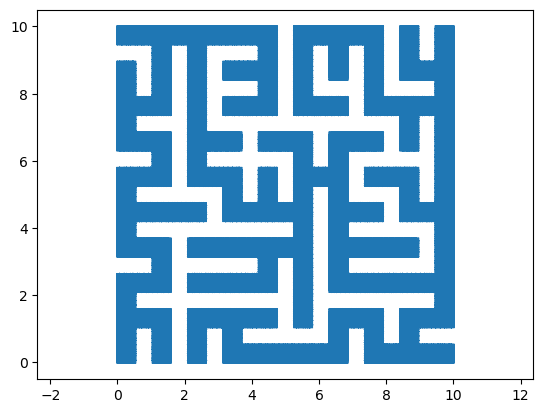

In [9]:
## make a rectanlge
a, b = 10, 10
N = 15

## buld it
# pts, tris = tri_rectangle(a, b, N)
# pts, tris = tri_circle(5, N)
pts, tris = tri_maze(10, 10, 10 / 19, N)
# pts, tris = tri_sphere(10, 4)
# pts, tris = tri_torus(1, 3, N)
n_pts = pts.shape[0]

# matricies
damp_mat, stiff_mat = build_matricies(pts, tris)

## plot it
fig, ax = plt.subplots()
ax.axis('equal')
ax.triplot(
        pts[:, 0],
        pts[:, 1],
        triangles=tris,
    )

In [10]:
pts.shape[0] / (5**2 * np.pi)

182.54435352868026

#### PDE 1 (Zebra Stripes)
From Jeong et al. "Numerical simulation of the zebra pattern formation on a three-dimensional model".

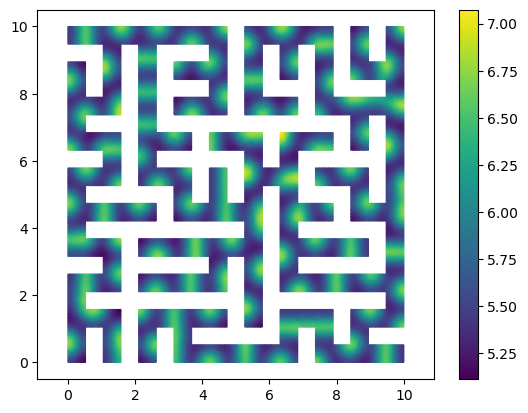

In [11]:
## pde
# gamma[1] = 0.04 and k1 = 7 should make spots instead
N = 2
gamma = np.array([1, 0.01])
k1 = 7
k2 = 11
r = lambda u: np.column_stack((
        k1 * (u[:, 1] - u[:, 0] * u[:, 1] / (1 + u[:, 1]**2)),
        k2 - u[:, 1] - 4 * u[:, 0] * u[:, 1] / (1 + u[:, 1]**2),
    ))

## initial condition
np.random.seed(0)
u0 = np.random.uniform(-1, 1, (n_pts, N))

## solve it
tmax = 100
dt = 0.1
u = solve_fem(r, gamma, tmax, dt, u0, damp_mat, stiff_mat)

## plot it
plt.axis('equal')
cb = plt.tripcolor(pts[:, 0], pts[:, 1], u[-1, :, 0], triangles=tris, shading='gouraud')
plt.colorbar(cb)

In [12]:
# from matplotlib import animation
# from IPython.display import HTML

# fig, ax = plt.subplots()
# fig.set_figheight(6)
# fig.set_figwidth(8)
# fig.suptitle('$t = {0}$')
# cb = ax.scatter(pts[:, 0], pts[:, 1], c=u[0, :, 0])
# cax = fig.colorbar(cb).ax
# fig.tight_layout()
# ax.axis('equal')

# def update(i):
#     # foramtting
#     fig.suptitle(f'$t = {i * dt:.4f}$')

#     # plot u
#     ax.clear()
#     cb = ax.tripcolor(pts[:, 0], pts[:, 1], u[i, :, 0], triangles=tris, shading='gouraud')
#     fig.colorbar(cb, cax=cax)

# # animate it
# plt.close()  # dont show empty figure
# anim = animation.FuncAnimation(fig, update, frames=range(u.shape[0])[::10], interval=100, cache_frame_data=False, repeat=False)
# HTML(anim.to_html5_video())

[0. 0. 1.]
[5.49803691 5.5525869  5.51594084]

[0.         0.46464646 0.53535354]
[5.53925209 5.49803691 5.45367831]

[0.07070707 0.         0.92929293]
[5.32225445 5.42622091 5.39784351]

[0.         0.39393939 0.60606061]
[5.27919799 5.32225445 5.26118368]

[0.         0.85858586 0.14141414]
[5.18305712 5.19983663 5.1681506 ]

[0.67676768 0.         0.32323232]
[5.15867389 5.16647797 5.1681506 ]

[ 152.            9.21212121 -160.21212121]
[5.44154277 5.46927875 5.44600659]

[ 152.           10.74747475 -161.74747475]
[5.44154277 5.46927875 5.44600659]

[ 152.           12.28282828 -163.28282828]
[5.44154277 5.46927875 5.44600659]

[ 152.           13.81818182 -164.81818182]
[5.44154277 5.46927875 5.44600659]

[ 152.           15.35353535 -166.35353535]
[5.44154277 5.46927875 5.44600659]

[0.88888889 0.         0.11111111]
[5.43105109 5.4087877  5.41059272]

[0.42424242 0.         0.57575758]
[5.62934613 5.51255421 5.51180659]

[0.         0.04040404 0.95959596]
[5.80947494 5.6293461

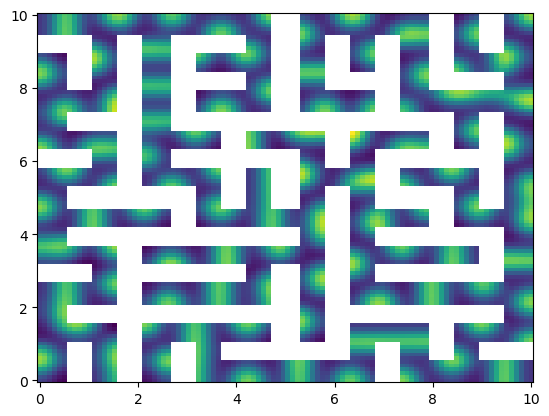

In [ ]:
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
x, y = np.meshgrid(x, y)

from src.fem import _psi_T, _areas_2d

def u_func(x, y, pts, tris, u, tol = 1e-10, max_size=100000):
    '''
    Evaluates u at x, y
    x: x coordinate to evaluate at
    y: y coordinate to evaluate at
    pts: Points of the u values
    tris: Trinagle indicies
    u: U values at each pt
    tol: Error tolerance for convexity, just use the default  
    max_size: If bigger than this, uses a for loop instead of numpy arrays
    for memory reasons, just use the default
    '''
    ## setup
    pts_T = pts[tris]

    ## evaluate function at each point
    A_T = _areas_2d(pts_T)
    (xi, xj, xk), (yi, yj, yk) = pts_T.T
    # if pts_T.shape[0] > max_size:  # size check before we extend the arrats
    #     return 
    uxy = np.empty_like(x)
    for i in np.ndindex(uxy.shape):
        psi_i = _psi_T(x[i], y[i], xj, xk, yj, yk, A_T)
        psi_j = _psi_T(x[i], y[i], xk, xi, yk, yi, A_T)
        psi_k = _psi_T(x[i], y[i], xi, xj, yi, yj, A_T)

        ## get triangle point is in
        lb = 0 - tol
        ub = 1 + tol
        tri_idx = ((lb <= psi_i) & (psi_i <= ub) & (lb <= psi_j) & (psi_j <= ub) & (lb <= psi_k) & (psi_k <= ub)).argmax()
        psi = np.stack((psi_i[tri_idx], psi_j[tri_idx], psi_k[tri_idx]), axis=-1)
        ui = u[tris[tri_idx]]

        # caluate result
        if (psi < lb).any() or (psi > ub).any():
            uxy[i] = np.nan
        else:
            uxy[i] = (psi * ui).sum()
    
    return uxy

uxy = u_func(x, y, pts, tris, u[-1, :, 0])

plt.pcolormesh(x, y, uxy)

#### PDE 2 (Zebra Stripes)
From Landge et al. "Pattern formation mechanisms of self-organizing reaction-diffusion systems".

In [ ]:
# ## pde
# # gamma[1] = 0.04 and k1 = 7 should make spots instead
# N = 2
# gamma = np.array([0.2, 10])
# x0 = 0.1
# mux, muy = 5, 5
# Kx = 0.
# r = lambda u: np.column_stack((
#         (u[:, 0]**2 / (1 + Kx * u[:, 0]**2) + x0) / u[:, 1] - mux * u[:, 0],
#         u[:, 0]**2 - muy * u[:, 1],
#     ))

# ## initial condition
# np.random.seed(0)
# u0 = np.random.uniform(-1, 1, (n_pts, N))

# ## solve it
# tmax = 100
# dt = 0.001
# u = solve_fem(r, gamma, tmax, dt, u0, damp_mat, stiff_mat)

# ## plot it
# plt.axis('equal')
# cb = plt.tripcolor(pts[:, 0], pts[:, 1], u[-1, :, 0], triangles=tris, shading='gouraud')
# plt.colorbar(cb)

KeyboardInterrupt: 